# 오디오 처리(Audio Processing)

* 소리는 진동으로 인한 공기의 압축으로 생성
* 압축이 얼마나 됐느냐에 따라 진동하며, 공간이나 매질을 전파해 나가는 현상인 Wave(파동)으로 표현
* 파동에서 얻을 수 있는 정보
  + 위상(Phase; Degress of displacement)
  + 진폭(Amplitude; Intensity)
  + 주파수(Frequency)

![](https://miro.medium.com/max/700/0*QFVha2lCgyhKjhuO.gif)





## 오디오 라이브러리

* librosa는 각종 음성 처리에 유용한 라이브러리
* colab 환경에서 torchaudio는 별도 설치가 필요
* 해당 예제에서는 torchaudio를 이용해 음성 데이터를 가져옴

In [1]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa, librosa.display
import torch, torchaudio
import IPython.display as ipd

## 오디오 데이터 

*   pytorch의 torchaudio를 사용해 내장 데이터셋을 가져옴
*   데이터가 크기 때문에 시간이 많이 소요

In [4]:
train_dataset = torchaudio.datasets.LIBRISPEECH('./', url='train-clean-100', download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH('./', url='test-clean', download=True)

  0%|          | 0.00/331M [00:00<?, ?B/s]



*   불러온 데이터 확인
  *   첫번째 줄에서는 소리 데이터 확인 가능
  *   두번째 줄에선 해당 데이터의 sampling rate 확인 가능





In [14]:
test_dataset[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)



*   불러온 데이터의 형상을 확인
*   데이터 길이만으로는 음성이 몇초에 해당하는지(duration)를 알 수 없음



In [15]:
test_dataset[1][0].shape

torch.Size([1, 52400])

## 샘플링(Sampling)

### Sampling

* 음성을 처리하기 위해 아날로그 정보를 잘게 쪼개 이산적인 디지털 정보로 표현해야 함
* 이때 무한히 쪼개서 저장할 수는 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값을 사용, 이를 샘플링이라 함
* 주로 사용할 때 시간을 기준으로 아날로그 정보를 쪼개는 Time Domain 방식을 사용

* Sampling rate
  * sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정
  * 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남
* Sampling theorem
  * sampling rate가 최대 frequency보다 2배 커져야 함을 의미
  * 일반적으로 sampling은 인간의 청각 영역에 맞게 형성
    - Audio CD : 44.1 kHz(44100 sample/second)
    - Speech communication : 8 kHz(8000 sample/second)







*   음성의 duration은 데이터의 길이와 sampling rate를 나누어 확인 가능


In [16]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]             # sampling rate

print(audio_data, sr)
print('length:', len(audio_data))
print('duration:', len(audio_data)/sr)
ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


### Resampling

* Resampling은 sampling data의 sampling rate를 조정해 다시 sampling하는 것
* 이때 일반적으로 보간(interpolation)을 할때는 low-pass filter를 사용
* `librosa.resample`을 사용하면 편리하게 resampling 가능
* 현재 데이터는 `torch tensor`, `librosa`는 `numpy` 배열을 받아들이기 때문에 변환 필요
* sampling rate를 절반으로 줄여, 길이도 절반으로 준 것을 확인할 수 있음


In [18]:
audio_np = audio_data.numpy()
y_8k = librosa.resample(audio_np, sr, 8000)

print(len(audio_np), len(y_8k))
ipd.Audio(y_8k, rate=8000)

52400 26200


In [19]:
audio_np = audio_data.numpy()
y_4k = librosa.resample(audio_np, sr, 4000)

print(len(audio_np), len(y_4k))
ipd.Audio(y_4k, rate=4000)

52400 13100


### Normalization & Quantization

*   데이터간 음량이 제각각인 경우 normalization을 하여 amplitude를 [-1, 1] 범위로 조정
*   여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용



In [20]:
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [21]:
bit = 8
max_value = 2 ** (bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

### Mu-Law Encoding

* 사람의 귀는 작은소리의 차이는 잘잡아내는데 반해 소리가 커질수록 그 차이를 잘 느끼지 못함
* 이러한 특성을 wave값을 표현하는데 반영해 작은 값에는 높은 분별력을, 큰 값끼리는 낮은 분별력을 갖도록 함



In [22]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

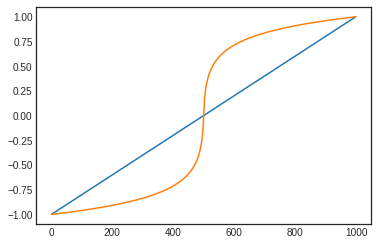

In [23]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.plot(x), plt.plot(x_mu)
plt.show()

In [24]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

# 오디오 표현(Audio Representation)

* Sampling된 discrete한 데이터를 표현
  + 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation 방법
  + 시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation

## Waveform - Time-Domain Representation

* Waveform은 오디오의 자연적인 표현
* 시간이 x축으로 그리고 amplitude가 y축으로 표현

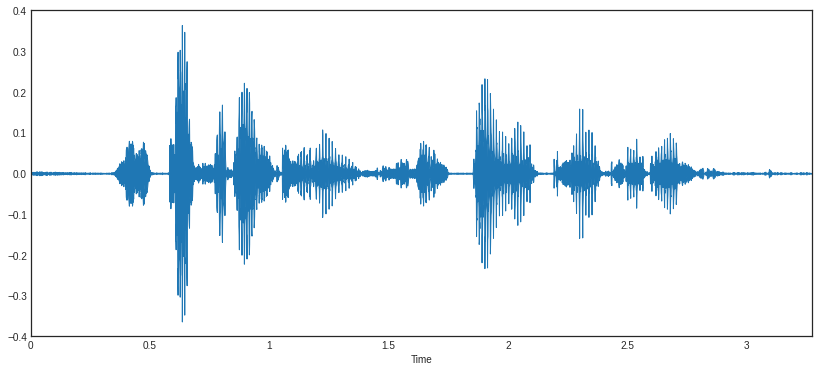

In [25]:
fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(audio_np[:100000], sr=sr);

## 정현파(Sinusoid) - Time-Frequency Representation

![](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png)

* 모든 신호는 주파수(frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinusolida signal)의 조합으로 나타낼 수 있음
* 푸리에 변환은 조합된 정현파의 합(하모니) 신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법

In [26]:
def sinusoid(A, f, pha, fs, t):
    t = np.arange(0, t, 1.0/fs)
    x = A * np.cos(2*np.pi*f*t + pha)
    return x

In [27]:
A, f, pha, fs, t = 0.9, 340, np.pi/2, 22050, 1

In [28]:
sin = sinusoid(A, f, pha, fs, t)

In [29]:
A, f, pha, fs, t = 0.9, 260, np.pi/2, 22050, 1

In [30]:
sin2 = sinusoid(A, f, pha, fs, t)

In [31]:
complex_wav = sin + sin2

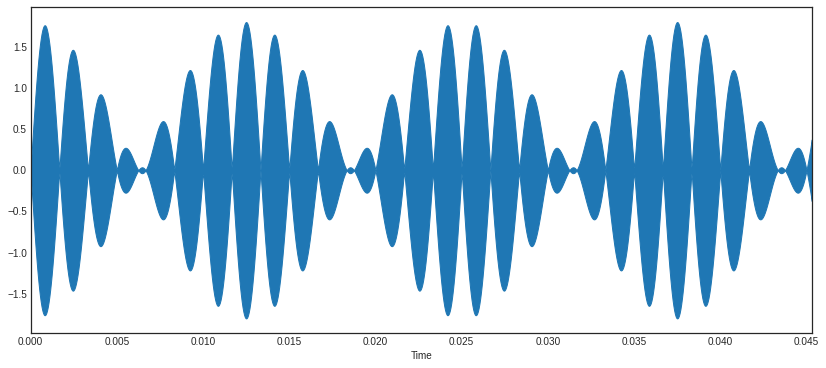

In [35]:
fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(complex_wav[:1000], sr=fs);

In [36]:
ipd.Audio(sin + sin/2 + sin/4, rate=fs)

In [37]:
ipd.Audio(sin2 + sin2/2 + sin2/4, rate=fs)

In [38]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, fs=22050, amplitude_max=0.5):
    N = int(duration + fs)
    t = np.arange(N) / fs
    x = []
    for p in pitches:
        omega = 2 ** ((p - 69) / 12) * 440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x / np.max(x)
    return x

In [40]:
duration, fs = 1, 22050
pitches = [36, 48, 60, 72, 84, 96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, fs=fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}')
ipd.Audio(x, rate=fs)

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


## 푸리에 변환(Fourier Fransform)


* 푸리에 변환은 임의의 입력 신호를 다양한 주파수를 갖는 주기 함수들의 합으로 분해하여 표현하는 것을 의미
* 푸리에 변환 식
$$
A_k = \frac{1}{T} \int_{-\frac{T}{2}}^\frac{T}{2} f(t) \, \exp \left( -i\cdot 2\pi \frac{k}{T} t \right) \, dt
$$
$$
y(t)=\sum_{k=-\infty}^\infty A_k \, \exp \left( i\cdot 2\pi\frac{k}{T} t \right)
$$



* 위 식에는 주기 함수들은 포함되어 있지 않음
* 오일러 공식에 따라 다음과 같이 지수 함수와 주기 함수간 관계를 나타낼 수 있음
$$
e^{i\theta} = \cos{\theta} + i\sin{\theta}
$$

* 해당 식을 오일러 공식에 따라 다음과 같이 표현 가능

$$
\exp \left( i\cdot 2\pi\frac{k}{T} t \right) = \cos\left({2\pi\frac{k}{T}}\right) + i\sin\left({2\pi\frac{k}{T}}\right)
$$

*   결국 푸리에 변환은 입력 신호에 상관없이 sin, cos 같은 주기 함수들의 합으로 분해 가능함을 나타냄

### 이산 푸리에 변환(Discrete Fourier Transform, DFT)



*   우리가 샘플링한 데이터는 discrete data라고 할 수 있음
*   위의 푸리에 변환을 이산 영역으로 생각해볼 수 있음
*   우리가 수집한 데이터 $y_n$에서 이산 시계열 데이터가 주기 N으로 반복한다고 할때, DFT는 주파수와 진폭이 다른 N개의 사인 함수 합으로 표현 가능
$$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} Y_k \cdot \exp \left( i\cdot 2\pi\frac{k}{N} n \right)
$$

*   위 식을 보면 k의 range가 0부터 $N-1$로 변화했음을 알 수 있음 
*   이때 Spectrum $Y_{k}$는 원래의 시계열 데이터에 대한 퓨리에 변환값

$$
Y_k = \sum_{n=0}^{N-1} y_n\cdot \exp \left( -i\cdot 2\pi\frac{k}{N} n \right)
$$

  * $y_{n}$ : input signal
  * $n$ : Discrete time index
  * $k$ : discrete frequency index
  * $Y_{k}$ : k번째 frequeny에 대한 Spectrum의 값



* DFT 수식을 코드로 나타내면 다음과 같음

### Short-Time Fourier Transform(STFT)



*   DFT는 시간에 흐름에 따라 신호의 수파수가 변했을때, 어느 시간대에 주파수가 변하는지 모름
*   STFT는 시간의 길이를 나눠서 이제 퓨리에 변환
*   주파수의 특성이 시간에 따라 달라지는 사운드를 분석하는 방법이며 우리가 사용하는 signal 데이터에 적합
*   시계열 데이터를 일정한 시간 구간 (window size)로 나누고, 각 구간에 대해서 스펙트럼을 구함

*   STFT에 대한 식과 설명은 다음과 같음

$$
X(l,k) = \sum_{n=0}^{N-1} w(n) x(n+lH)\exp^{\frac{-2\pi k n}{N}}
$$

- $N$ : FFT size
    - Window를 얼마나 많은 주파수 밴드로 나누는가

- Duration
    - 샘플링 레이트를 window로 나눈 값
    - $T= window/SR$
    - T(Window) = 5T(Signal), duration은 신호주기보다 5배 이상 길게 잡아야함
    - 440Hz 신호의 window size는 5*(1/440)

- $w(n)$ : Window function
    - 일반적으로 Hann window 사용

- $n$ : Window size
    - Window 함수에 들어가는 Sample의 양
    - 작을수록 Low-frequency resolution을 가지게 되고, high-time resolution을 가짐
    - 길수록 High-frequency, low time resolution을 가짐
    
- $H$ : Hop size
    - 윈도우가 겹치는 사이즈, 일반적으로는 1/4정도를 겹치게 함

* STFT의 결과는 즉 시간의 흐름(Window)에 따른 Frequency영역별 Amplitude를 반환



#### 윈도우 함수(Window Function)

* Window function 기능
  1. main-lobe를 제어
  2. side-lobe의 레벨 trade-off를 제어
  3. 깁스 현상(불연속을 포함하는 파형이 푸리에 합성되었을 때 불연속 값에서 나타나는 불일치 현상) 방지



#### 윈도우 크기(Window Size)




*   window size는 time과 frequency의 resolutions를 제어
  * short-window - 낮은 frequency resolutuon, 높은 time resolution
  * long-window - 높은 frequency resolution, 낮은 time resolution



## 스펙트로그램(Spectrogram)

* 스펙트로그램은 소리나 파동을 시각화하여 파악하기 위한 도구
* 파형과 스펙트럼의 특징이 조합되어 있음
* 시간 축과 주파수 축의 변화에 따라 진폭의 차이를 인쇄 농도나 표시 색상 차이로 표현



### Linear Frequency Scale



*   순음(single tone)들의 배음 구조를 파악하는데 적절
*   분포가 저주파수 영역에 치우쳐져 있음



### 멜 스케일(Mel Scale)



*   주파수 단위를 다음 공식에 따라 멜 스케일로 변환
$$
m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)
$$
*   일반적으로 mel-scaled bin을 FFT size보다 조금 더 작게 만듬
*   해당 scale을 적용해 spectogram을 만든 것이 melspectogram


### 바크 스케일(Bark Scale)

* 귀가 인식하는 주파수의 영역은 대략 $20Hz~2000Hz$로 가정, 하지만 주파수에 대한 사람의 인식은 비선형적
* 귀와 뇌의 가청대역을 24개의 대역으로 나눈것을 Bark라고 함
* Bark scale은 $500Hz$ 이하에서는 $100Hz$의 대역폭을, $500Hz$ 이상에서는 각 대역의 중심수파수의 대략 20%에 해당하는 대역폭을 가짐
  
  `20, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500 ( Hz )`

### Log Compression



*   신호를 $ 10 * log10(\frac{S}{ref})$의 단위로 신호를 스케일링
*   spectrogram을 데시벨 유닛으로 전환


## 이산 코사인 변환(Discrete Cosine Transform, DCT)



*   DCT는 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 데이터의 양을 줄이는 방식
*   저 주파수에 에너지가 집중되고 고 주파수 영역에 에너지가 감소

## 오디오 특징 추출(Audio Feature Extraction)

* 모든 오디오 신호는 많은 기능으로 구성
* 해결하려는 문제와 관련된 특성 추출 필요

### 스펙트럼 센트로이드(Spectral Centroid)

* 주파수의 스펙트럼의 가중 평균과 같음

### 스펙트럼 롤오프(Spectral Rolloff)

* 신호의 모양을 측정
* 고주파수가 0으로 감소하는 주파수를 나타냄

### 스펙트럼 대역폭

* 스펙트럼 대역폭은 최대 피크의 절반 (또는 최대 절반의 전체 너비 [FWHM])에서 빛의 대역 폭으로 정의되며 두 개의 수직 빨간색 선과 파장 축에서 λSB로 표시

### 제로 크로싱 비율(Zero Crossing Rate)

* 신호의 부드러움을 측정하는 매우 간단한 방법은 해당 신호의 세그먼트 내에서 제로 크로싱 수를 계산하는 것
* 음성 신호는 느리게 진동 (예를 들어, 100Hz 신호는 초당 제로 100을 교차하는 반면 무성 마찰음은 초당 3000 개의 제로 교차를 가질 수 있음)

### Mel-Frequency Cepstral Coefficients (MFCC)

* 신호의 MFCC(Mel frequency cepstral coefficients)는 스펙트럼 포락선의 전체 모양을 간결하게 설명하는 작은 기능 집합 (일반적으로 약 10-20)
* 인간 목소리의 특성을 모델링

### 크로마그램(Chromagram)

* 색도 특성 또는 벡터는  일반적으로 각각의 피치 클래스의 많은 에너지가, {C, C #, D, D 번호는, E, ..., B} 신호 내에 존재하는 방법을 나타내는 요소 특징 벡터
* 음악 작품 간의 유사성 측정을 설명하는 강력한 방법 제공

# 오디오 필터(Audio Filter)